# Web

In [1]:
from web import FootballBoxscore, unique_game_links

In [9]:
links_2018 = unique_game_links("2018")
links_2019 = unique_game_links("2019")
links_2020 = unique_game_links("2020")

links = np.hstack([links_2018,links_2019,links_2020])
all_scores = [ FootballBoxscore("https://www.pro-football-reference.com/" + link) for link in links]
for fbs in tqdm(all_scores):
    try: 
        fbs.full_scrape()
    except AttributeError:
        print ("Advanced Table Not Found")
        break
        
# In case you want to cache the results
#import pickle
#pickle.dump(all_scores, open("/home/tom/Cache/box.pkl",'wb'))
#all_scores = pickle.load(open("/home/tom/Cache/box.pkl",'rb'))

100%|██████████| 695/695 [07:07<00:00,  1.62it/s]


# Data

In [4]:
from data import ScoreTable, OffenseTable, DefenseTeamTable, OffenseTeamTable
from data import AdvancedPassingTable, AdvancedRecievingTable, AdvancedRushingTable 

In [5]:
# Feature space classes will get references to these, so make sure they are built
score_table        = ScoreTable(refresh=True, boxscores=all_scores)
offense_table      = OffenseTable(refresh=True, boxscores=all_scores)
adv_passing_table  = AdvancedPassingTable(refresh=True, boxscores=all_scores)
adv_recv_table     = AdvancedRecievingTable(refresh=True, boxscores=all_scores)
adv_rush_table     = AdvancedRushingTable(refresh=True, boxscores=all_scores)
defense_table      = DefenseTeamTable(refresh=True, boxscores=all_scores)
offense_team_table = OffenseTeamTable(refresh=True, boxscores=all_scores)

100%|██████████| 695/695 [00:03<00:00, 176.03it/s]


# Model

In [6]:
from model import QuarterbackFeatureSpaceTable, PositionPlayerFeatureSpaceTable, DefenseFeatureSpaceTable
qb_featurespace    = QuarterbackFeatureSpaceTable()
pl_featurespace    = PositionPlayerFeatureSpaceTable()
df_featurespace    = DefenseFeatureSpaceTable()

686it [00:09, 70.99it/s]
6001it [01:41, 58.88it/s]
672it [00:06, 104.01it/s]


# Simulation

In [1]:
from sim import PayoutTable, BacktestLinksTable, HistoricalSalaryTable, BacktestStandingsTable
from sim import BacktestPlayerPerformanceTable, BacktestPredictionsTable

In [4]:
payoutTable           = PayoutTable(refresh=True)
backtestLinks         = BacktestLinksTable(refresh=True)
historicalSalary      = HistoricalSalaryTable(refresh=True, max_week=13)
historicalStandings   = BacktestStandingsTable(refresh=True)
historicalPerformance = BacktestPlayerPerformanceTable(refresh=True)
backtestPredictions   = BacktestPredictionsTable(refresh=True)

100%|██████████| 47/47 [00:13<00:00,  3.53it/s]
10it [00:09,  1.08it/s]
100%|██████████| 45/45 [00:11<00:00,  3.76it/s]
10it [00:08,  1.17it/s]
100%|██████████| 45/45 [00:11<00:00,  3.77it/s]
10it [00:08,  1.18it/s]
45it [00:00, 73.40it/s]
380it [00:06, 60.37it/s]
26it [00:00, 99.43it/s]
43it [00:00, 72.77it/s]
380it [00:06, 60.12it/s]
26it [00:00, 98.17it/s] 
36it [00:00, 73.69it/s]
322it [00:05, 59.19it/s]
22it [00:00, 103.87it/s]
44it [00:00, 75.96it/s]
344it [00:05, 62.00it/s]
24it [00:00, 104.97it/s]
41it [00:00, 75.34it/s]
308it [00:04, 62.62it/s]
22it [00:00, 104.85it/s]
43it [00:00, 75.55it/s]
338it [00:05, 62.41it/s]
24it [00:00, 104.78it/s]
42it [00:00, 75.19it/s]
346it [00:05, 62.66it/s]
22it [00:00, 104.96it/s]
40it [00:00, 75.20it/s]
308it [00:04, 61.67it/s]
22it [00:00, 103.26it/s]
47it [00:00, 74.89it/s]
349it [00:05, 61.54it/s]
22it [00:00, 105.68it/s]
41it [00:00, 74.23it/s]
313it [00:05, 60.45it/s]
22it [00:00, 103.20it/s]


# Double Up Backtest

In [2]:
from sim import DoubleupStandingsTable

In [5]:
historicalPerformance = BacktestPlayerPerformanceTable(refresh=False)
backtestPredictions   = BacktestPredictionsTable(refresh=False)
doubleupStandings     = DoubleupStandingsTable(refresh=True)

10it [00:08,  1.18it/s]


In [6]:
perf = historicalPerformance.table.copy()
pred = backtestPredictions.table.reset_index().rename(columns={'level_0':'name', 'level_1':'week', \
                                                               'level_2':'year', 0:'pred'}).copy()
btTable = perf.join(pred.set_index(['name','week','year']), on=['name','week','year'])
btTable = btTable.dropna(subset=['DK salary'])
btTable = btTable[~((btTable.FPTS == 0) & (btTable['Roster Position'] != "DST"))] # Don't start anyone thats out

In [7]:
import numpy as np
from tqdm import tqdm
from sim import run_doubleup_backtest

In [9]:
out = {}
for wk, results in tqdm(btTable.groupby('week')):
    if wk < 5.0: 
        continue
    out[wk] = {}
    for num_teams_to_stack in [1,2,3]:
        for num_players_in_stack in [2,3]:
            x = np.array([num_teams_to_stack, num_players_in_stack])
            key = ".".join([str(i) for i in x]) 
            out[wk][key] = run_doubleup_backtest(x,results, doubleupStandings.table.copy())
            print(wk, key, out[wk][key])

  0%|          | 0/10 [00:00<?, ?it/s]

5 1.2 240.0
5 1.3 -400.0
5 2.2 0.0
5 2.3 -360.0
5 3.2 -80.0


 40%|████      | 4/10 [00:07<00:10,  1.79s/it]

5 3.3 -160.0
6 1.2 -400.0
6 1.3 -400.0
6 2.2 -400.0
6 2.3 0.0
6 3.2 -360.0


 50%|█████     | 5/10 [00:14<00:16,  3.36s/it]

6 3.3 -120.0
7 1.2 400.0
7 1.3 400.0
7 2.2 320.0
7 2.3 280.0
7 3.2 160.0


 60%|██████    | 6/10 [00:21<00:18,  4.51s/it]

7 3.3 160.0
8 1.2 -320.0
8 1.3 -320.0
8 2.2 -280.0
8 2.3 -280.0
8 3.2 -280.0


 70%|███████   | 7/10 [00:29<00:16,  5.50s/it]

8 3.3 -160.0
9 1.2 400.0
9 1.3 360.0
9 2.2 320.0
9 2.3 360.0
9 3.2 280.0


 80%|████████  | 8/10 [00:36<00:12,  6.11s/it]

9 3.3 320.0
10 1.2 400.0
10 1.3 240.0
10 2.2 400.0
10 2.3 360.0
10 3.2 320.0


 90%|█████████ | 9/10 [00:43<00:06,  6.36s/it]

10 3.3 240.0
11 1.2 400.0
11 1.3 240.0
11 2.2 400.0
11 2.3 360.0
11 3.2 360.0


100%|██████████| 10/10 [00:50<00:00,  5.08s/it]

11 3.3 160.0


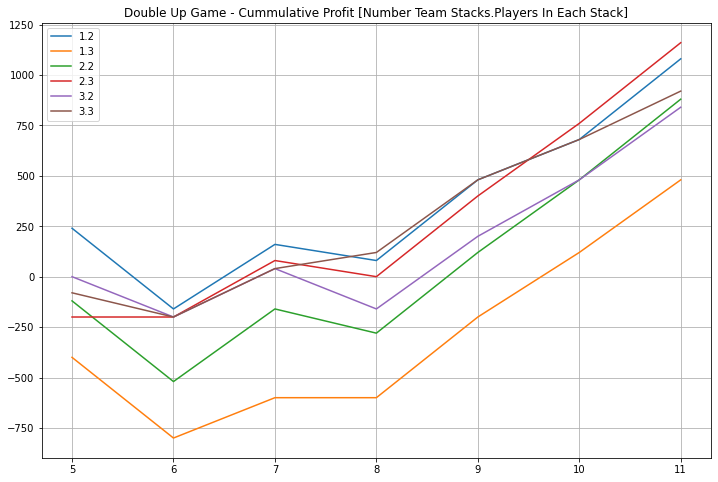

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(out).T.cumsum().plot(figsize=(12,8), title='Double Up Game - Cummulative Profit [Number Team Stacks.Players In Each Stack]')
plt.grid(True)